In [1]:
import __init__
#
from taxi_common.file_handling_functions import get_all_files, load_pickle_file
#
from IPython.display import HTML, display
import plotly.plotly as py
import igraph as ig
import numpy as np
import pandas as pd
import folium

def text_display(text, font_size):
    display(HTML('<font size=%d>' % font_size + text + '</font>'))

%matplotlib inline 

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



# Datasets
* Periods 
    * Y2009: 11 months are considered (except December)
    * Y2010: 11 months are considered (except October) 
    * Y2011: 7 months are available (01, 06, 07, 08, 09, 11, 12)
    * Y2012: 9 months are available (01, 02, 03, 04, 05, 06, 07, 08, 09) 
    * Filtering in day of week
        * Only dataset recorded on **Monday to Tursday** is considered
        * On the other day of week (Friday, Saturday and Sunday), taxi drivers have different strategy for picking up passengers
* Time frames
    * **2:00 PM to 11:00 PM** (14:00 ~ 23:00)
* **Only single shift drivers** (one shift drivers who don't share his vehicle with others)

# Zone generation
* Define zones which split Singapore in grid form
    * 96 columns and 53 rows (total 5088 zones)
* Area of a grid is 0.5km X 0.5km

In [2]:
from helping_functions import draw_grid_on_map
#
from taxi_common.sg_grid_zone import get_sg_grid_xy_points
#
x_points, y_points = get_sg_grid_xy_points()
xc, yc = (x_points[0] + x_points[-1]) / float(2), (y_points[0] + y_points[-1]) / float(2)

map_osm = folium.Map(location=[yc, xc], zoom_start=11)
map_osm = draw_grid_on_map(map_osm, x_points, y_points)
map_osm

# Data processing for trip instances
* Time frame
    * Set a time frame based on trip's timestamp
* Zone
    * Find the specific zone where the trip occured, based on the start location (GPS coordinates) and end location
    * For simplicity, record zone's grid coordinates
* Example;

In [3]:
from community_analysis import ft_trips_dir, ft_trips_prefix

df = pd.read_csv('%s/%s' % (ft_trips_dir, '%s0901.csv' % ft_trips_prefix))
df.head()

time    did  day  timeFrame  zi  zj  distance  duration  fare
0  1230789600   7007    1         14  65  14       5.2       420   660
1  1230789600  35586    1         14  21  14      21.0      1440  1910
2  1230789600  18597    1         14  51  28       6.0       660   780
3  1230789600  22058    1         14  51  40       2.0       360   540
4  1230789600  35583    1         14  59  29       7.2       780   800

# Distribution generation
* For each month, count the number of pick-up for time frame and zone
* Get year’s counting about the number of pick-up by aggregating months’ count
* Get the joint distribution
* Example;

## Joint distribution

In [4]:
from community_analysis import tf_zone_distribution_dir, tf_zone_distribution_prefix
df = pd.read_csv('%s/%s2009.csv' % (tf_zone_distribution_dir, tf_zone_distribution_prefix))
df[40:45]

timeFrame      zid   probability
40         14  z025049  0.000000e+00
41         14  z064020  5.234164e-05
42         14  z028010  0.000000e+00
43         14  z050027  7.722326e-05
44         14  z031015  7.735218e-07

## Marginal distribution of time frame

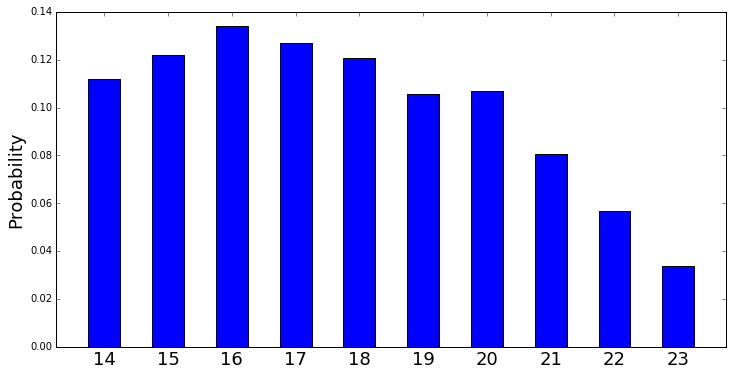

In [5]:
from taxi_common.charts import simple_barchart
df_tf = df.groupby(['timeFrame']).sum().loc[:, ['probability']].reset_index()
simple_barchart((12, 6), df_tf['timeFrame'], 'Probability', df_tf['probability'])

## Marginal distribution of zone

In [6]:
from taxi_common import sg_grid_geojson
#
df_zone = df.groupby(['zid']).sum().loc[:, ['probability']].reset_index()
#
map_osm = folium.Map(location=[yc, xc], zoom_start=11)
map_osm.geo_json(geo_path=sg_grid_geojson, data=df_zone,
             columns=['zid', 'probability'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.75, line_opacity=0.2)
map_osm

/usr/local/lib/python2.7/site-packages/folium/folium.py:504: UserWarning:

This method is deprecated. Please use Map.choropleth instead.

/usr/local/lib/python2.7/site-packages/folium/folium.py:506: FutureWarning:

'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.



## Conditional distribution
### Time frame X=16 (Biggest probability in marginal distribution of time fram)

In [7]:
df_condition = df[(df['timeFrame'] == 16)]
df_zone = df_condition.groupby(['zid']).sum().loc[:, ['probability']].reset_index()
#
map_osm = folium.Map(location=[yc, xc], zoom_start=11)
map_osm.geo_json(geo_path=sg_grid_geojson, data=df_zone,
             columns=['zid', 'probability'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.75, line_opacity=0.2)
map_osm

### Time frame X=23 (Smallest probability in marginal distribution of time fram)

In [8]:
df_condition = df[(df['timeFrame'] == 23)]
df_zone = df_condition.groupby(['zid']).sum().loc[:, ['probability']].reset_index()
#
map_osm = folium.Map(location=[yc, xc], zoom_start=11)
map_osm.geo_json(geo_path=sg_grid_geojson, data=df_zone,
             columns=['zid', 'probability'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.75, line_opacity=0.2)
map_osm

# Community detection
## Pick-up distributions of single shift driver generation
* For each single shift driver, generate the distribution like the above joint distribution
## Directed weighted graph generation
    * For each month, generate a directed weighted graph generation as follows;
        * Generate a queue data structure which saves driver ids in arrival order for each zone
        * A link is generated if two drivers pick up passengers at the same zone within 30 minutes
![link_weight_increment](src/link_weight_increment.png)
        * A driver can pick up two passenger at the same zone within 30 minutes 
            * Link's weight can increase more than one
        * Ensure only updating link's weight one time when a driver pick a passenger one
        * Link weight's update with consideration in **removing homophily**
            * Initial weight of the link is 0
            * $D_{1}$: a driver’s joint distribution (time frame and zone)
            * $D_{2}$: the previous driver’s joint distribution
            * $W$: increment, $W=max(0, D_{2}(T=t~and~Z=z) - D_{1}(T=t~and~Z=z))$ 
        * Assumption
            * There is information about all drivers’ pick-up distribution
            * If a driver picks up a passenger at a specific zone at specific time often (many experiences), he can make better decision in whether or not call other drivers


### Graph aggregation
    * Aggregate graphs
    * Type
        * Year
        * Three month rolling horizon (for checking evolution of communities)

## Group partitioning
* Set a threshold values and filtering out meaningless links
    * If there are many links between drivers, it will results in few big communities which include lots of drivers
    * A threshold values represents standard for removing meaningless links
        * Links whose weight is less than a threshold value will be ignored in the following analysis
        * The following results use **99.995 percentile** for the threshold value
* Apply a paritionning algorithm at the modified links (graph)
    * Use [a Python library](https://github.com/vtraag/louvain-igraph), which uses the louvain method described in Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)

# Analysis results about communies
## Community statistics summary
    * Only consider groups whose minimum number of driver is bigger than 10 as communities

In [9]:
from community_analysis import CHOSEN_PERCENTILE, MIN_NUM_DRIVERS
from community_analysis import group_dir
from taxi_common.file_handling_functions import get_all_files
percentile_dirname = 'percentile(%.3f)' % CHOSEN_PERCENTILE
percentile_dirpath = '%s/%s' % (group_dir, percentile_dirname)
#
yyyy = '2009'
year_dirpath = '%s/%s' % (percentile_dirpath, yyyy)
#
headers = ['groupName', '# drivers', '# links', 'sum(weights) / # drivers']
L_gn, L_numDrivers, L_numLinks, L_tie_strength = range(4)
df_data = {k: [] for k in headers}
for group_fn in get_all_files(year_dirpath, '', '.pkl'):
    _, _, yyyy, g_name = group_fn[:-len('.pkl')].split('-')
    igG = ig.Graph.Read_Pickle('%s/%s' % (year_dirpath, group_fn))
    drivers = [v['name'] for v in igG.vs]
    if len(drivers) < MIN_NUM_DRIVERS:
        continue
    weights = [e['weight'] for e in igG.es]
    df_data[headers[L_gn]].append(g_name)
    df_data[headers[L_numDrivers]].append(len(drivers))
    df_data[headers[L_numLinks]].append(len(weights))
    df_data[headers[L_tie_strength]].append(sum(weights) / float(len(drivers)))
df = pd.DataFrame(df_data)[headers]
df

groupName  # drivers  # links  sum(weights) / # drivers
0      G(0)        193      997                 44.785659
1      G(1)        101      196                 14.550048
2      G(2)         67      131                 16.472956
3      G(3)         61      227                 24.773972
4      G(4)         58       95                 10.857340
5      G(5)         43       49                  7.991926
6      G(6)         40       44                 10.783333
7      G(7)         13       13                  7.855800
8      G(8)         13       12                 12.687234
9      G(9)         12       11                  7.969961

## Trip instances including previous community driver

In [10]:
from community_analysis import CHOSEN_PERCENTILE
from community_analysis import com_trips_dir, com_trips_prefix
percentile_dirname = 'percentile(%.3f)' % CHOSEN_PERCENTILE
percentile_dirpath = '%s/%s' % (group_dir, percentile_dirname)
yyyy = '2009'
com_trips_fpath = '%s/%s/%s%s.csv' % (com_trips_dir, percentile_dirname, com_trips_prefix, yyyy)
df = pd.read_csv(com_trips_fpath)
df.tail()

time    did  day  timeFrame  zi  zj  distance  duration  fare  \
1176632  1259596560  18506   30         23  63  30       4.6       480   650   
1176633  1259596620  17488   30         23  53  10      28.0      1740  3140   
1176634  1259596620  19359   30         23  68  21       8.6       600   939   
1176635  1259596620  18656   30         23  20  24       1.7       180   370   
1176636  1259596620   8327   30         23  85  27       6.7       540  1090   

        comName prevComDriver  
1176632    G(1)         32384  
1176633    G(1)         32384  
1176634    G(5)         37159  
1176635    G(8)         15463  
1176636    G(0)         31658

## Distribution (Five biggest communities)

In [11]:
from helping_functions import draw_service_locations
#
gn_names = ['G(%d)' % i for i in range(5)]
five_com_df = df[(df['comName'].isin(gn_names))]
#
map_osm = draw_service_locations(five_com_df)
map_osm

helping_functions.py:31: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



## Contribution and benefit ratio

In [12]:
target_group = 'G(0)'
num_trips, num_benefit, num_contribution = {}, {}, {}
com_df = df[(df['comName'] == target_group)]
count = 0 
for did, prevComDriver in com_df[['did', 'prevComDriver']].values:
    if not num_trips.has_key(did):
        num_trips[did] = 0
        num_benefit[did] = 0
    num_trips[did] += 1
    if type(eval(prevComDriver)) != type(eval('None')):
        num_benefit[did] += 1
        if not num_contribution.has_key(eval(prevComDriver)):
            num_contribution[eval(prevComDriver)] = 0
        num_contribution[eval(prevComDriver)] += 1

In [13]:
headers = ['did', '# trips', '# benefits', '# contributions', '% benefit', '% contribution']
L_did, L_num_trips, \
L_num_benefits,  L_num_contributions, \
L_ratio_benefits,  L_ratio_contributions = range(6)
df_data = {k: [] for k in headers}

for did, nt in num_trips.iteritems():
    df_data[headers[L_did]].append(did)
    df_data[headers[L_num_trips]].append(nt)
    nb = num_benefit[did]
    cn = num_contribution[did] if num_contribution.has_key(did) else 0
    df_data[headers[L_num_benefits]].append(nb)
    df_data[headers[L_num_contributions]].append(cn)
    df_data[headers[L_ratio_benefits]].append(nb / float(nt))
    df_data[headers[L_ratio_contributions]].append(cn / float(nt))
df = pd.DataFrame(df_data)[headers]

In [14]:
text_display('% contribution', 5)
text_display('HEAD', 3)
display(HTML(df.sort('% contribution', ascending=False).head().to_html()))
text_display('TAIL', 3)
display(HTML(df.sort('% contribution', ascending=False).tail().to_html()))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [15]:
text_display('% benefit', 5)
text_display('HEAD', 3)
display(HTML(df.sort('% benefit', ascending=False).head().to_html()))
text_display('TAIL', 3)
display(HTML(df.sort('% benefit', ascending=False).tail().to_html()))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [16]:
from community_analysis import CHOSEN_PERCENTILE
from community_analysis import com_trips_dir, com_trips_prefix
percentile_dirname = 'percentile(%.3f)' % CHOSEN_PERCENTILE
percentile_dirpath = '%s/%s' % (group_dir, percentile_dirname)
yyyy = '2009'
com_trips_fpath = '%s/%s/%s%s.csv' % (com_trips_dir, percentile_dirname, com_trips_prefix, yyyy)
df = pd.read_csv(com_trips_fpath)
#
target_group = 'G(3)'
num_trips, num_benefit, num_contribution = {}, {}, {}
com_df = df[(df['comName'] == target_group)]
count = 0 
for did, prevComDriver in com_df[['did', 'prevComDriver']].values:
    if not num_trips.has_key(did):
        num_trips[did] = 0
        num_benefit[did] = 0
    num_trips[did] += 1
    if type(eval(prevComDriver)) != type(eval('None')):
        num_benefit[did] += 1
        if not num_contribution.has_key(eval(prevComDriver)):
            num_contribution[eval(prevComDriver)] = 0
        num_contribution[eval(prevComDriver)] += 1
headers = ['did', '# trips', '# benefits', '# contributions', '% benefit', '% contribution']
L_did, L_num_trips, \
L_num_benefits,  L_num_contributions, \
L_ratio_benefits,  L_ratio_contributions = range(6)
df_data = {k: [] for k in headers}

for did, nt in num_trips.iteritems():
    df_data[headers[L_did]].append(did)
    df_data[headers[L_num_trips]].append(nt)
    nb = num_benefit[did]
    cn = num_contribution[did] if num_contribution.has_key(did) else 0
    df_data[headers[L_num_benefits]].append(nb)
    df_data[headers[L_num_contributions]].append(cn)
    df_data[headers[L_ratio_benefits]].append(nb / float(nt))
    df_data[headers[L_ratio_contributions]].append(cn / float(nt))
df = pd.DataFrame(df_data)[headers]
text_display('% contribution', 5)
text_display('HEAD', 3)
display(HTML(df.sort_values(by='% contribution', ascending=False).head().to_html()))
text_display('TAIL', 3)
display(HTML(df.sort_values(by='% contribution', ascending=False).tail().to_html()))
text_display('% benefit', 5)
text_display('HEAD', 3)
display(HTML(df.sort_values(by='% benefit', ascending=False).head().to_html()))
text_display('TAIL', 3)
display(HTML(df.sort_values(by='% benefit', ascending=False).tail().to_html()))

# Plan
* Define core members with % benefit and % contribution (or with centrality)
* Get some statistics for each community
    * Fare (productivity ?)
    * % benefit
    * % contribution
* Do Chi-squre test for communities' distribution
* Compare other years' results
    * (Finished data preprocessing)
* Check evolution of communities